In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pandas_profiling

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

Поскольку в задании требуется предсказывать метки 'Adoption' и 'Transfer', остальные данные пока проигнорируем.

Проверим также количество данных по разным видам животных

In [211]:
data = pd.read_csv('aac_shelter_outcomes.csv')
data = data[data['outcome_type'].isin(['Adoption', 'Transfer'])]
data['animal_type'].value_counts()

Dog          29570
Cat          26055
Other          772
Bird           206
Livestock        8
Name: animal_type, dtype: int64

С точки зрения вида животных видим, что собак и кошек в данных подавляющее большинство (98%).
Другие виды животных можно детальнее посмотреть позже, пока же исключим их из данных.

In [212]:
data = data[data['animal_type'].isin(['Dog', 'Cat'])]
data

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male
...,...,...,...,...,...,...,...,...,...,...,...,...
78250,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,Adoption,Neutered Male
78251,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female
78252,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,Adoption,Neutered Male
78254,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,Adoption,Spayed Female


In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55625 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  55624 non-null  object
 1   animal_id         55625 non-null  object
 2   animal_type       55625 non-null  object
 3   breed             55625 non-null  object
 4   color             55625 non-null  object
 5   date_of_birth     55625 non-null  object
 6   datetime          55625 non-null  object
 7   monthyear         55625 non-null  object
 8   name              38196 non-null  object
 9   outcome_subtype   28725 non-null  object
 10  outcome_type      55625 non-null  object
 11  sex_upon_outcome  55625 non-null  object
dtypes: object(12)
memory usage: 5.5+ MB


In [214]:
data.profile_report()

Один из ключевых параметром, которые нас будут интересовать это 'age_upon_outcome', проверим корректность зачений этого поля

In [215]:
data['age_upon_outcome'].value_counts()

1 year       9318
2 months     8830
2 years      7019
3 months     3209
3 years      2983
1 month      2889
4 months     2158
4 years      1625
5 months     1525
5 years      1499
3 weeks      1387
6 months     1356
2 weeks      1208
10 months    1005
6 years       987
8 months      955
8 years       851
7 years       795
4 weeks       765
7 months      758
10 years      594
9 months      484
1 weeks       456
1 week        400
9 years       391
11 months     369
12 years      282
3 days        214
11 years      194
2 days        193
13 years      141
6 days        138
4 days        119
1 day         119
5 days         89
14 years       83
15 years       77
0 years        71
5 weeks        47
16 years       21
17 years       14
20 years        2
18 years        2
19 years        2
Name: age_upon_outcome, dtype: int64

В целом нас все устраивает - допускаем, что в приют могут попасть как новорожденные животные (несколько дней), так и старые (15-20 лет). Исключение составляют записи со значением '0 years' - посмотрим на них внимательнее

In [216]:
data[data['age_upon_outcome'] == '0 years']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
1726,0 years,A677846,Cat,Domestic Shorthair Mix,Black,2014-04-29T00:00:00,2014-04-29T12:35:00,2014-04-29T12:35:00,NaN,Partner,Transfer,Unknown
2101,0 years,A666602,Dog,Beagle/Chihuahua Shorthair,White,2013-11-04T00:00:00,2013-11-04T14:55:00,2013-11-04T14:55:00,NaN,Partner,Transfer,Intact Female
2401,0 years,A678821,Cat,Domestic Shorthair Mix,Black,2014-05-13T00:00:00,2014-05-13T13:20:00,2014-05-13T13:20:00,NaN,Partner,Transfer,Unknown
5113,0 years,A678820,Cat,Domestic Shorthair Mix,Blue Tabby,2014-05-13T00:00:00,2014-05-13T13:20:00,2014-05-13T13:20:00,NaN,Partner,Transfer,Unknown
6097,0 years,A666605,Dog,Beagle/Chihuahua Shorthair,White,2013-11-04T00:00:00,2013-11-04T14:59:00,2013-11-04T14:59:00,NaN,Partner,Transfer,Intact Female
...,...,...,...,...,...,...,...,...,...,...,...,...
71576,0 years,A755170,Dog,Chihuahua Shorthair Mix,White,2017-07-30T00:00:00,2017-07-30T16:50:00,2017-07-30T16:50:00,NaN,Partner,Transfer,Intact Female
73832,0 years,A730078,Cat,Domestic Shorthair Mix,Brown Tabby,2016-06-28T00:00:00,2016-06-28T11:33:00,2016-06-28T11:33:00,NaN,Partner,Transfer,Unknown
73920,0 years,A728454,Dog,Chow Chow Mix,Black/White,2016-06-04T00:00:00,2016-06-04T19:16:00,2016-06-04T19:16:00,NaN,Partner,Transfer,Unknown
74913,0 years,A710575,Cat,Domestic Shorthair Mix,Orange Tabby/White,2015-08-24T00:00:00,2015-08-24T18:56:00,2015-08-24T18:56:00,NaN,Partner,Transfer,Unknown


Сопоставим для этих записей ('0 years') поля 'date_of_birth' и 'datetime'. Часть записей по всей видимости относится к новорожденным животным, то есть '0 лет' указано корректно. Однако для некоторых записей поля 'date_of_birth' и 'datetime' не совпадают, таким образом в поле 'age_upon_outcome' некорректное значение. Отмаркируем такие записи и удалим их.

In [217]:
def check_dates(row):
    date_of_birth = row['date_of_birth']
    year_db = int(date_of_birth[:4])
    month_db = int(date_of_birth[5:7])
    day_db = int(date_of_birth[8:10])
    
    datetime = row['datetime']
    year_dt = int(datetime[:4])
    month_dt = int(datetime[5:7])
    day_dt = int(datetime[8:10])
    
    if (row['age_upon_outcome'] == '0 years') and ((year_db - year_dt != 0) or (month_db - month_dt != 0) or (day_db - day_dt != 0)):
        return 1
    else:
        return 0

data['date_error'] = data.apply(check_dates, axis=1)

data.drop(data[data.date_error == 1].index, inplace=True)

data.drop(['date_error'], axis=1, inplace=True)


Проверим наличие пустых значений среди наших параметров. Такие есть в полях 'age_upon_outcome','name' и 'outcome_subtype'. Нас не устраивают пустые значения в поле 'age_upon_outcome' - их немного, удалим их.

In [218]:
for column in data.columns:
    bdate = data[column]
    print(pd.isnull(bdate).value_counts())

False    55618
True         1
Name: age_upon_outcome, dtype: int64
False    55619
Name: animal_id, dtype: int64
False    55619
Name: animal_type, dtype: int64
False    55619
Name: breed, dtype: int64
False    55619
Name: color, dtype: int64
False    55619
Name: date_of_birth, dtype: int64
False    55619
Name: datetime, dtype: int64
False    55619
Name: monthyear, dtype: int64
False    38192
True     17427
Name: name, dtype: int64
False    28722
True     26897
Name: outcome_subtype, dtype: int64
False    55619
Name: outcome_type, dtype: int64
False    55619
Name: sex_upon_outcome, dtype: int64


In [219]:
data.dropna(subset=['age_upon_outcome'], inplace=True)

Преобразуем категориальное поле 'sex_upon_outcome' в поля с соответствующими значениями признака

In [220]:
oh_enc = OneHotEncoder()
ohe_sex_upon_outcome = oh_enc.fit_transform(data[['sex_upon_outcome']]).toarray()
ohe_sex_upon_outcome = pd.DataFrame(ohe_sex_upon_outcome, columns=oh_enc.categories_[0])

data = data.reset_index(drop=True)
data = data.join(ohe_sex_upon_outcome)
# data.drop(['sex_upon_outcome'], axis=1, inplace=True)

data.head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,0.0,0.0,0.0,1.0,0.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,0.0,0.0,1.0,0.0,0.0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0
5,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,Transfer,Spayed Female,0.0,0.0,0.0,1.0,0.0
6,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,Adoption,Intact Female,1.0,0.0,0.0,0.0,0.0
7,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0
8,2 years,A673652,Dog,Papillon/Border Collie,Black/White,2012-02-28T00:00:00,2014-03-28T14:39:00,2014-03-28T14:39:00,Fancy,Partner,Transfer,Neutered Male,0.0,0.0,1.0,0.0,0.0
9,2 months,A677679,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0


Добавим признак 'empty_name' для животных, у которых не было имени

In [221]:
data.loc[:, 'empty_name'] = 1 * pd.isnull(data['name'])
data

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0,1
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,0.0,0.0,0.0,1.0,0.0,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,0.0,0.0,1.0,0.0,0.0,0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55613,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,1
55614,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0,1
55615,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0
55616,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0,1


Добавим признаки 'месяц' и 'год', чтобы учесть возможное изменение трендов во времени (год от года + сезональность)

In [222]:
def get_year(row):
    date_string = row['datetime']
    return date_string[:4]

def get_month(row):
    date_string = row['datetime']
    return date_string[5:7]

data['year'] = data.apply(get_year, axis=1)
data['month'] = data.apply(get_month, axis=1)

data.sample(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,year,month
1012,3 months,A660950,Cat,Domestic Shorthair Mix,Brown Tabby/White,2013-07-16T00:00:00,2013-11-01T17:54:00,2013-11-01T17:54:00,*Lil Sister,NaN,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0,0,2013,11
45078,2 months,A757869,Cat,Domestic Shorthair Mix,Brown Tabby,2017-07-25T00:00:00,2017-10-08T19:08:00,2017-10-08T19:08:00,Maui,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2017,10
4123,15 years,A672148,Cat,Persian Mix,Orange Tabby/White,1999-02-05T00:00:00,2014-02-13T18:54:00,2014-02-13T18:54:00,*Gabby,NaN,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0,0,2014,02
26278,6 months,A716716,Cat,Domestic Medium Hair Mix,Black,2015-11-02T00:00:00,2016-05-14T16:06:00,2016-05-14T16:06:00,Lemore,Foster,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2016,05
6981,2 months,A689305,Cat,Siamese Mix,Lynx Point,2014-07-18T00:00:00,2014-10-09T15:37:00,2014-10-09T15:37:00,*Monte,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2014,10


Преобразуем категориальные поля 'month' и 'year' в поля с соответствующими значениями признака

In [223]:
ohe_month = oh_enc.fit_transform(data[['month']]).toarray()
ohe_month = pd.DataFrame(ohe_month, columns=oh_enc.categories_[0])

data = data.reset_index(drop=True)
data = data.join(ohe_month)


ohe_year = oh_enc.fit_transform(data[['year']]).toarray()
ohe_year = pd.DataFrame(ohe_year, columns=oh_enc.categories_[0])

data = data.reset_index(drop=True)
data = data.join(ohe_year)

data.head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,09,10,11,12,2013,2014,2015,2016,2017,2018
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,2 years,A673652,Dog,Papillon/Border Collie,Black/White,2012-02-28T00:00:00,2014-03-28T14:39:00,2014-03-28T14:39:00,Fancy,Partner,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,2 months,A677679,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Преобразуем категориальное поле 'age_upon_outcome' в числовой признак 'возраст в неделях', чтобы использовать возраст животного в модели 

In [224]:
def age_to_weeks(df):
    result = {}
    for record in df['age_upon_outcome'].unique():
        if type(record) != type(""):
            result[record] = -1
        else:
            num, period = record.split()
            if period in ["year", "years"]:
                result[record] = int(num) * 52
            elif period in ["month", "months"]:
                result[record] = int(num) * 4.33
            elif period in ["week", "weeks"]:
                result[record] = int(num)
            elif period in ["day", "days"]:
                result[record] = int(num) / 7
                
    df['age_weeks'] = df['age_upon_outcome'].map(result).astype(float)
              
    return df

data = age_to_weeks(data)
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,10,11,12,2013,2014,2015,2016,2017,2018,age_weeks
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.00
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,52.00
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.00
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,468.00
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,17.32


Добавим бинарный признак 'Adoption' для случаев, когда животное забрали из приюта

In [225]:
def transfer(outcome_type):
    if outcome_type == 'Adoption':
        return 1
    else:
        return 0

data['Adoption'] = data['outcome_type'].apply(transfer)
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,11,12,2013,2014,2015,2016,2017,2018,age_weeks,Adoption
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.00,0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,52.00,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.00,1
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,468.00,0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,17.32,0


In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55618 entries, 0 to 55617
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age_upon_outcome  55618 non-null  object 
 1   animal_id         55618 non-null  object 
 2   animal_type       55618 non-null  object 
 3   breed             55618 non-null  object 
 4   color             55618 non-null  object 
 5   date_of_birth     55618 non-null  object 
 6   datetime          55618 non-null  object 
 7   monthyear         55618 non-null  object 
 8   name              38192 non-null  object 
 9   outcome_subtype   28721 non-null  object 
 10  outcome_type      55618 non-null  object 
 11  sex_upon_outcome  55618 non-null  object 
 12  Intact Female     55618 non-null  float64
 13  Intact Male       55618 non-null  float64
 14  Neutered Male     55618 non-null  float64
 15  Spayed Female     55618 non-null  float64
 16  Unknown           55618 non-null  float6

Удалим ненужные поля

In [227]:
data.drop(['age_upon_outcome'], axis=1, inplace=True)
data.drop(['animal_id'], axis=1, inplace=True)
data.drop(['outcome_type'], axis=1, inplace=True)
data.drop(['color'], axis=1, inplace=True)
data.drop(['date_of_birth'], axis=1, inplace=True)
data.drop(['datetime'], axis=1, inplace=True)
data.drop(['monthyear'], axis=1, inplace=True)
data.drop(['name'], axis=1, inplace=True)
data.drop(['outcome_subtype'], axis=1, inplace=True)
data.drop(['sex_upon_outcome'], axis=1, inplace=True)
data.drop(['year'], axis=1, inplace=True)
data.drop(['month'], axis=1, inplace=True)
data


,animal_type,breed,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,01,02,...,11,12,2013,2014,2015,2016,2017,2018,age_weeks,Adoption
0,Cat,Domestic Shorthair Mix,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.00,0
1,Dog,Beagle Mix,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,52.00,0
2,Dog,Pit Bull,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.00,1
3,Dog,Miniature Schnauzer Mix,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,468.00,0
4,Dog,Leonberger Mix,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,17.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55613,Dog,Golden Retriever/Labrador Retriever,0.0,0.0,1.0,0.0,0.0,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.33,1
55614,Dog,Golden Retriever/Labrador Retriever,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.33,1
55615,Dog,Mastiff Mix,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,156.00,1
55616,Dog,Standard Schnauzer,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.66,1


Теперь построим модели отдельно для собак и кошек - сначала собаки

In [205]:
dogs_data = data[data['animal_type'] == 'Dog']
dogs_data.drop(['animal_type'], axis=1, inplace=True)
dogs_data.drop(['breed'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55618 entries, 0 to 55617
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   animal_type    55618 non-null  object 
 1   breed          55618 non-null  object 
 2   Intact Female  55618 non-null  float64
 3   Intact Male    55618 non-null  float64
 4   Neutered Male  55618 non-null  float64
 5   Spayed Female  55618 non-null  float64
 6   Unknown        55618 non-null  float64
 7   empty_name     55618 non-null  int32  
 8   01             55618 non-null  float64
 9   02             55618 non-null  float64
 10  03             55618 non-null  float64
 11  04             55618 non-null  float64
 12  05             55618 non-null  float64
 13  06             55618 non-null  float64
 14  07             55618 non-null  float64
 15  08             55618 non-null  float64
 16  09             55618 non-null  float64
 17  10             55618 non-null  float64
 18  11    

C:\Users\Peter\anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Разделим выборку на обучаемую и тестовую

In [154]:
X = dogs_data.drop('Adoption', axis=1)  
y = dogs_data['Adoption'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)

Обучим модель

In [206]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))

0.926789141760351


Оценим значимость параметров

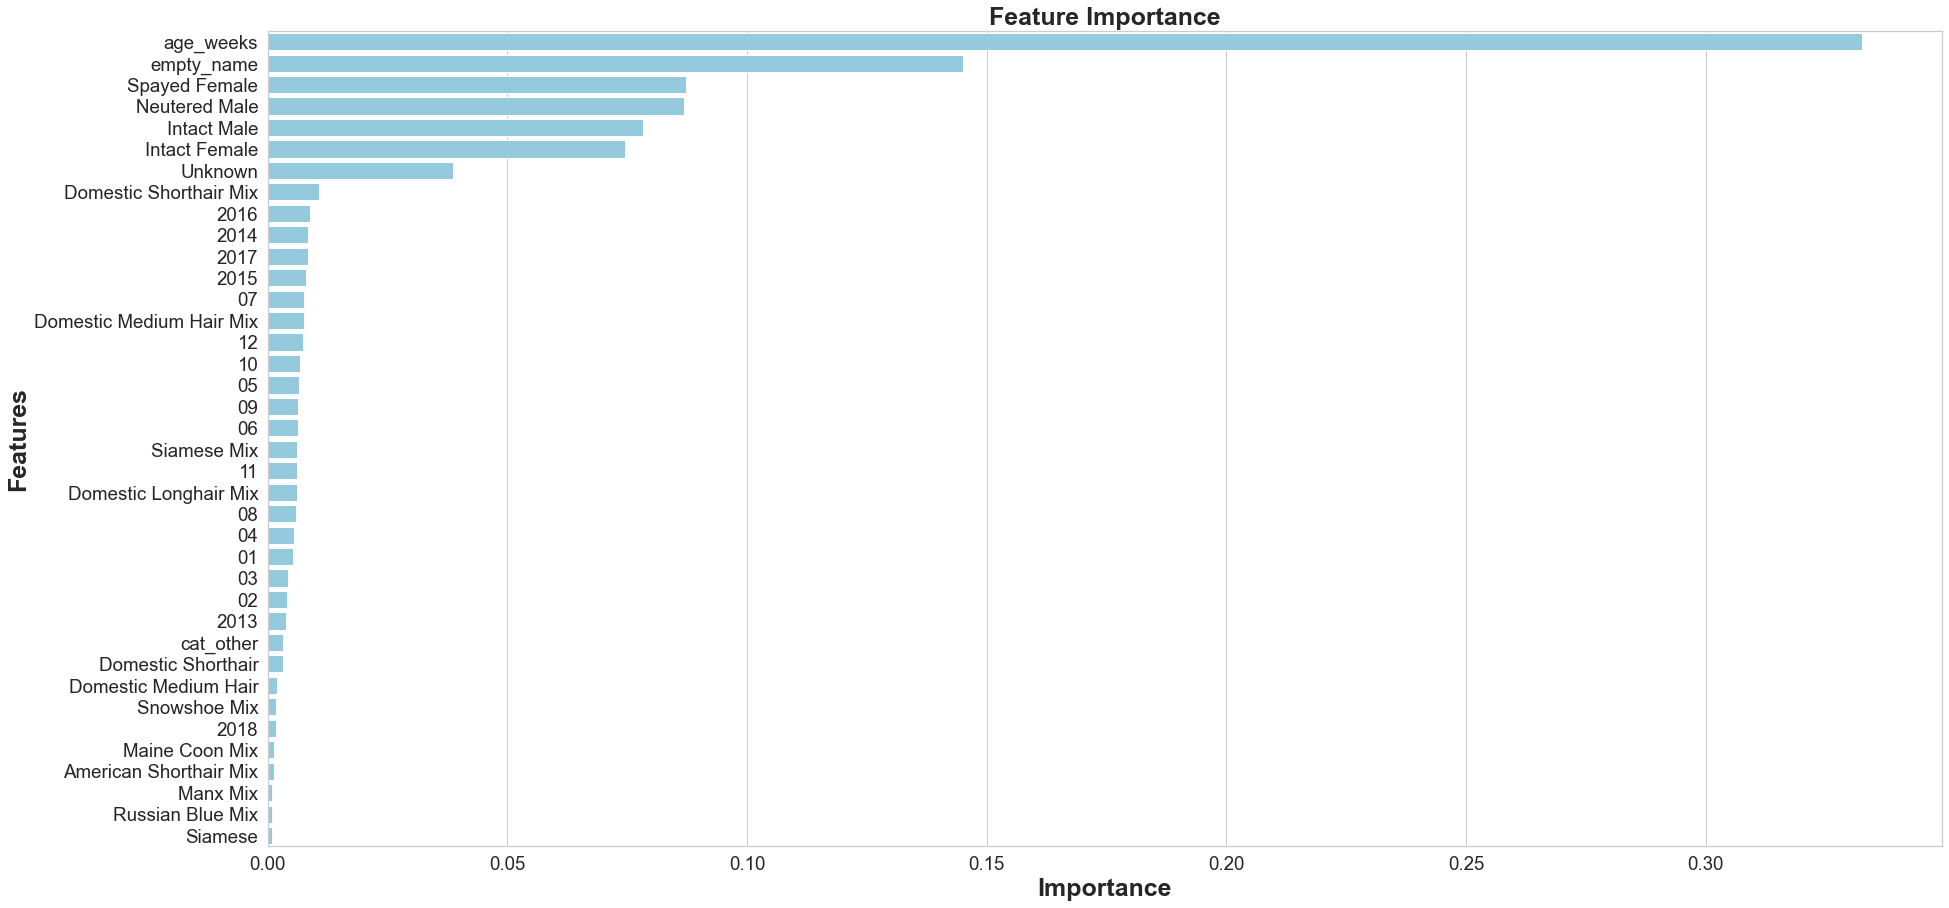

None

,Features,Gini-Importance
0,age_weeks,0.332639
1,empty_name,0.145046
2,Spayed Female,0.087300
3,Neutered Male,0.086857
4,Intact Male,0.078229
5,Intact Female,0.074564
6,Unknown,0.038691
7,Domestic Shorthair Mix,0.010717
8,2016,0.008848
9,2014,0.008391


In [207]:
feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Проверим модель с помощью матрицы ошибок - получили неплохие результаты: точность предсказания около 85%

In [208]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,3344,653
actual 1,501,3318


'Random Forest recall score'

0.8688138256087982

Теперь построим модель для кошек, здесь можно дополнительно использовать поле 'breed', чтобы попытаться улучшить модель на основе данных о породе животного

In [228]:
cats_data = data[data['animal_type'] == 'Cat']
cat_top_breed_list = list(cats_data['breed'].value_counts().head(12).index)
cat_top_breed_list

['Domestic Shorthair Mix',
 'Domestic Medium Hair Mix',
 'Domestic Longhair Mix',
 'Siamese Mix',
 'Domestic Shorthair',
 'American Shorthair Mix',
 'Snowshoe Mix',
 'Domestic Medium Hair',
 'Maine Coon Mix',
 'Manx Mix',
 'Siamese',
 'Russian Blue Mix']

Заменим редкие породы на 'other'

In [229]:
def cat_breed_clear(row):
    if row['animal_type'] == 'Cat':
        if row['breed'] in cat_top_breed_list:
            return row['breed']
        else:
            return 'cat_other'
    else:
        return row['breed']

# cat_breed_clear(test_data, cat_top_breed_list)


cats_data['breed'] = cats_data.apply(cat_breed_clear, axis=1)
# stats.head()
cats_data[cats_data['breed'] == 'cat_other']

C:\Users\Peter\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,animal_type,breed,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,01,02,...,11,12,2013,2014,2015,2016,2017,2018,age_weeks,Adoption
237,Cat,cat_other,1.0,0.0,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17.32,0
395,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,260.00,0
497,Cat,cat_other,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.00,1
778,Cat,cat_other,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,104.00,0
827,Cat,cat_other,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,676.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53513,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,104.00,1
53649,Cat,cat_other,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,17.32,1
54700,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,208.00,1
55474,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,416.00,1


In [230]:
ohe_cat_breed = oh_enc.fit_transform(cats_data[['breed']]).toarray()
ohe_cat_breed = pd.DataFrame(ohe_cat_breed, columns=oh_enc.categories_[0])

cats_data = cats_data.reset_index(drop=True)
cats_data = cats_data.join(ohe_cat_breed)
cats_data.head(10)


,animal_type,breed,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,01,02,...,Domestic Medium Hair Mix,Domestic Shorthair,Domestic Shorthair Mix,Maine Coon Mix,Manx Mix,Russian Blue Mix,Siamese,Siamese Mix,Snowshoe Mix,cat_other
0,Cat,Domestic Shorthair Mix,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cat,Domestic Shorthair Mix,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cat,Domestic Shorthair Mix,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cat,Domestic Shorthair Mix,0.0,1.0,0.0,0.0,0.0,1,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cat,Domestic Shorthair Mix,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Cat,Domestic Shorthair Mix,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Cat,Domestic Shorthair Mix,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Cat,Domestic Shorthair Mix,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Cat,Domestic Medium Hair Mix,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Cat,Siamese,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [231]:
cats_data.drop(['animal_type'], axis=1, inplace=True)
cats_data.drop(['breed'], axis=1, inplace=True)
cats_data.info()
# data['outcome_type'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26051 entries, 0 to 26050
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Intact Female             26051 non-null  float64
 1   Intact Male               26051 non-null  float64
 2   Neutered Male             26051 non-null  float64
 3   Spayed Female             26051 non-null  float64
 4   Unknown                   26051 non-null  float64
 5   empty_name                26051 non-null  int32  
 6   01                        26051 non-null  float64
 7   02                        26051 non-null  float64
 8   03                        26051 non-null  float64
 9   04                        26051 non-null  float64
 10  05                        26051 non-null  float64
 11  06                        26051 non-null  float64
 12  07                        26051 non-null  float64
 13  08                        26051 non-null  float64
 14  09    

Разделим выборку на обучаемую и тестовую

In [162]:
X = cats_data.drop('Adoption', axis=1)  
y = cats_data['Adoption'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)

Построим модель

In [163]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))

0.926789141760351


Оценим важность признаков

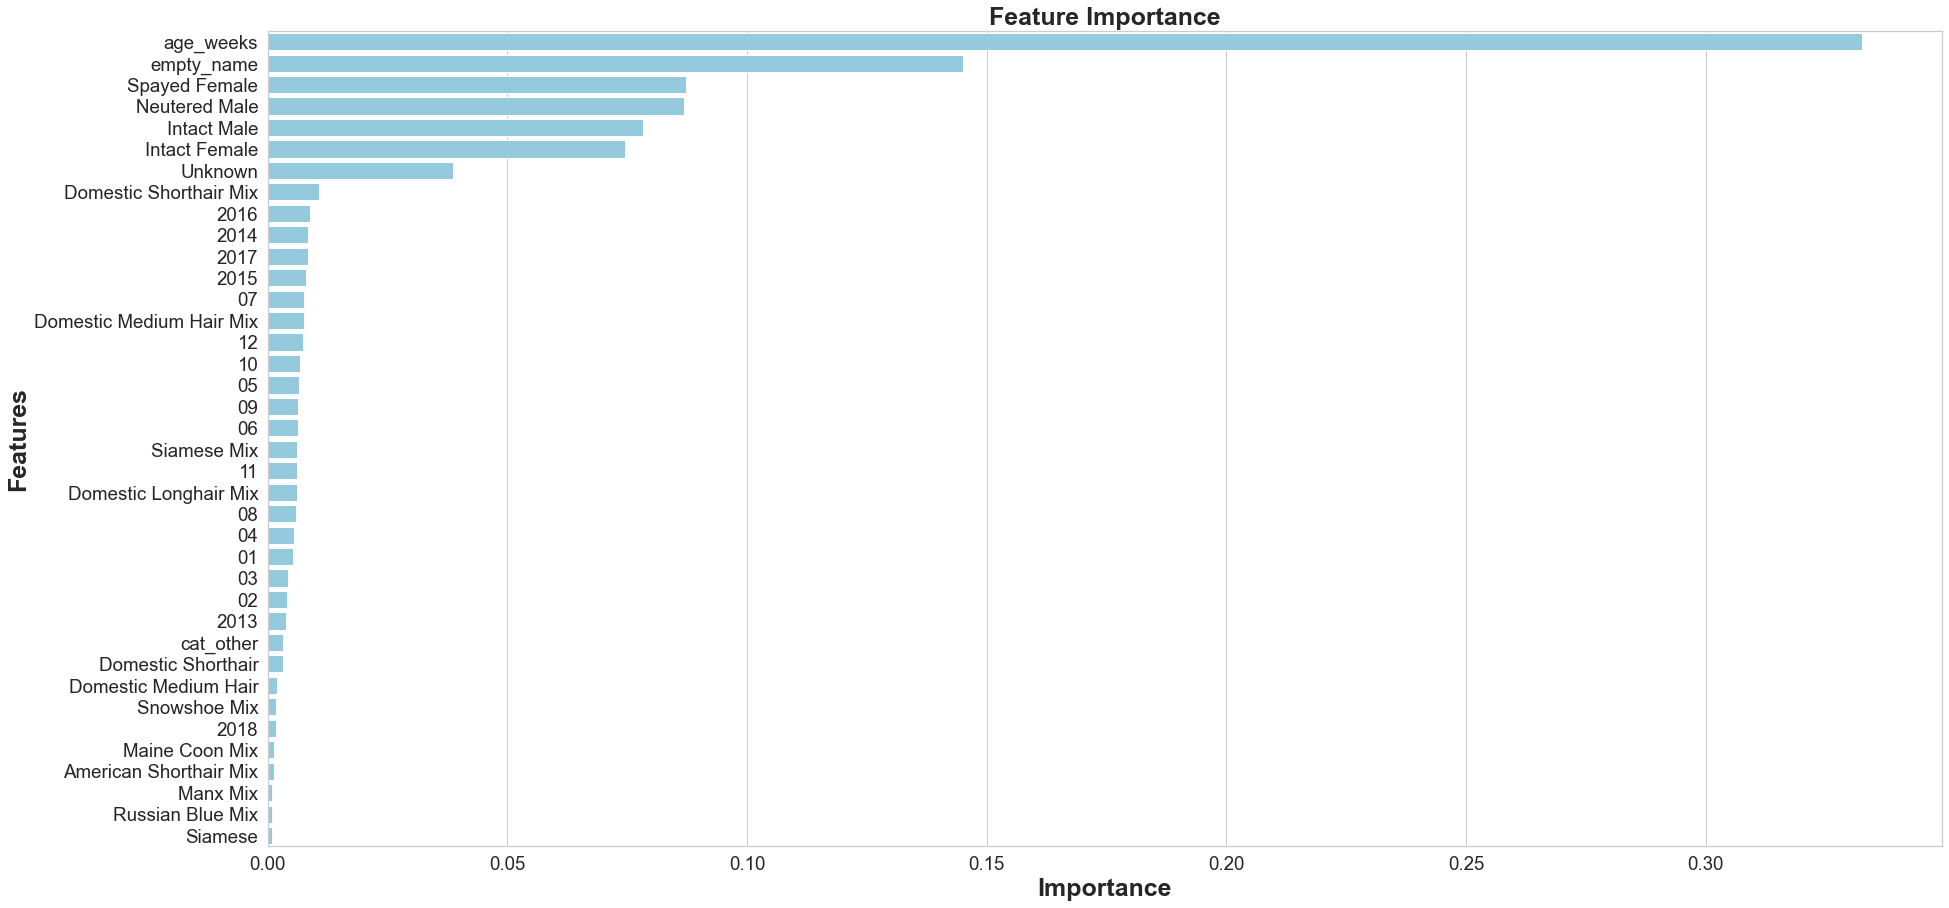

None

,Features,Gini-Importance
0,age_weeks,0.332639
1,empty_name,0.145046
2,Spayed Female,0.087300
3,Neutered Male,0.086857
4,Intact Male,0.078229
5,Intact Female,0.074564
6,Unknown,0.038691
7,Domestic Shorthair Mix,0.010717
8,2016,0.008848
9,2014,0.008391


In [232]:
feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Оценим эффективность модели

In [233]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,3344,653
actual 1,501,3318


'Random Forest recall score'

0.8688138256087982

Теперь проведем масштабирование данных и применим PCA

In [234]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

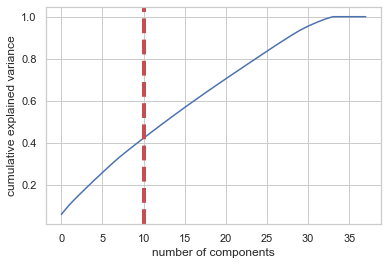

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.057789,0.057789
1,0.104250,0.046461
2,0.144778,0.040528
3,0.182759,0.037981
4,0.220554,0.037795
5,0.257237,0.036683
6,0.293580,0.036343
7,0.328200,0.034620
8,0.359905,0.031705
9,0.390915,0.031010


In [237]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=38)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(20))

In [238]:
columns = X_train.columns

pca = PCA(n_components=20)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [239]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=columns, index=pca_dims)
pca_test_df.head(20).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,PCA Component 10,PCA Component 11,PCA Component 12,PCA Component 13,PCA Component 14,PCA Component 15,PCA Component 16,PCA Component 17,PCA Component 18,PCA Component 19
Intact Female,-0.212306,0.205379,-0.094705,0.088614,0.166040,0.047120,-0.064530,0.017051,0.502321,-0.464712,0.084177,0.082727,-0.014868,-0.018369,-0.095315,0.108495,-0.086028,-0.151221,-0.098794,-0.131691
Intact Male,-0.227172,0.141348,-0.055527,0.136229,0.190903,0.040876,0.010251,-0.029241,-0.505947,0.398756,0.133745,-0.067931,0.068271,0.118623,0.097480,-0.112631,-0.183881,0.051786,-0.058360,-0.166397
Neutered Male,0.236109,-0.128951,-0.105437,0.472194,-0.525585,-0.175012,0.031211,-0.073681,0.031402,0.037180,0.007497,-0.021094,-0.005387,-0.007149,0.006253,-0.012430,0.035164,0.013694,0.026742,0.041990
Spayed Female,0.282915,-0.196478,0.168322,-0.498626,0.405916,-0.011079,-0.014343,0.101023,-0.089365,-0.073166,-0.055354,0.004805,-0.001928,-0.010543,-0.010402,-0.009138,0.083857,0.031905,0.058372,0.025828
Unknown,-0.287078,0.085399,0.090526,-0.239384,-0.269948,0.191372,0.045543,-0.032123,0.063397,0.177529,-0.200952,0.001903,-0.053991,-0.095482,0.011323,0.032622,0.149295,0.061020,0.064484,0.272888
empty_name,-0.448006,0.257133,0.034760,-0.011470,0.026469,0.182039,0.064992,-0.092410,0.038820,0.072439,-0.060880,-0.014871,0.013701,-0.001683,0.064764,0.076720,-0.068499,0.004596,-0.076522,0.022705
01,0.132339,-0.069818,0.463143,0.271877,0.052031,0.397686,-0.091855,0.013825,-0.027995,-0.049442,0.002959,0.012238,-0.002612,0.007170,0.012422,0.022183,-0.031999,0.015218,0.018702,0.017103
02,0.082443,-0.012071,0.093097,-0.050675,0.013460,-0.136119,0.081821,0.036329,0.075172,0.212765,-0.010429,-0.057029,0.028177,-0.069257,-0.046762,-0.217956,0.049296,-0.547340,-0.217324,-0.273038
03,-0.000926,0.007681,0.062484,-0.032917,-0.006454,-0.081163,0.043078,-0.004066,0.202416,0.137263,-0.058176,-0.066085,-0.082781,-0.018878,-0.014347,0.008233,0.071562,0.592294,-0.507092,-0.204376
04,-0.104531,0.066255,0.071290,-0.077054,-0.053218,0.019586,0.009344,-0.131504,0.193437,0.257303,-0.197944,-0.068869,-0.101582,-0.207704,0.327095,0.351796,0.043408,-0.164734,0.245913,-0.163477


Построим модель после применения PCA

In [240]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))

0.926789141760351

Оценим эффективность модели

In [241]:
y_pred_pca = rfc.predict(X_test_scaled_pca)

In [242]:
from sklearn.metrics import confusion_matrix
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])


In [243]:
display(conf_matrix_baseline_pca)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred_pca))

,predicted 0,predicted 1
actual 0,3296,701
actual 1,512,3307


'Baseline Random Forest recall score'

0.8659334904425242

Видим, что относительно исходной модели добиться улучшения не удалось